# Tutorial 1: Environment Creation and Training

In this tutorial, we will show a simple example of how to create a gym environment using [EAGERx](https://eagerx.readthedocs.io/en/master/).
Also, we will use this environment to train a policy using [Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/).

The following will be covered:
- Creating a [Graph](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html) with an [Object](https://eagerx.readthedocs.io/en/master/guide/api_reference/object/index.html)
- How to use this [Graph](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html) and a [Engine](https://eagerx.readthedocs.io/en/master/guide/api_reference/engine/index.html) to create an [Eagerx Environment](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html)
- How to train a policy with the [EAGERx Environment](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html)

In the remainder of this tutorial we will go more into detail on these concepts.


## Pendulum Swing-up

We will create an environment for solving the classic control problem of swinging up an underactuated pendulum, very similar to the [Pendulum-v1 environment](https://www.gymlibrary.ml/environments/classic_control/pendulum/).
Our goal is to swing up this pendulum to the upright position and keep it there, while minimizing the velocity of the pendulum and the input voltage.

Since the dynamics of a pendulum actuated by a DC motor are well known, we can simulate the pendulum by integrating the corresponding ordinary differential equations (ODEs):


$\mathbf{x} = \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix} \\ \dot{\mathbf{x}} = \begin{bmatrix} \dot{\theta} \\ \frac{1}{J}(\frac{K}{R}u - mgl \sin{\theta} - b \dot{\theta} - \frac{K^2}{R}\dot{\theta})\end{bmatrix}$

with $\theta$ the angle w.r.t. upright position, $\dot{\theta}$ the angular velocity, $u$ the input voltage, $J$ the inertia, $m$ the mass, $g$ the gravitational constant, $l$ the length of the pendulum, $b$ the motor viscous friction constant, $K$ the motor constant and $R$ the electric resistance.

<img src="./figures/pendulum.GIF" width="480" />


## Activate GPU (Colab only)

When in Colab, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down


## Notebook Setup

In order to be able to run the code, we need to install the *eagerx_tutorials* package.

In [1]:
try:
    import eagerx_tutorials
except ImportError:
    !{"echo 'Installing eagerx-tutorials with pip.' && pip install eagerx-tutorials >> /tmp/eagerx_install.txt 2>&1"}
    
    # Reload PIL (only required the first time)
    import importlib
    import PIL
    importlib.reload(PIL.TiffTags)

# Setup interactive notebook
# Required in interactive notebooks only.
from eagerx_tutorials import helper
helper.setup_notebook()

# Import eagerx
import eagerx
eagerx.set_log_level(eagerx.WARN)

Not running on CoLab.


## Let's get started

An `Object` is an entity that has inputs (sensors), outputs (actuators) and states (that can be reset at the beginning of an episode).

We are going to create one object (the pendulum). For this first tutorial, we don't want to go into details too much and start with existing objects.
Note that we import the pendulum.
While this might look like an unused import, it is not.
During the import, the pendulum object is registered and we can therefore make it based on its ID, i.e. *Pendulum*.

Before making the object, we will first obtain some info on the *Pendulum*, such that we know with what arguments we should make it.

In [2]:
from eagerx_tutorials.pendulum.objects import Pendulum

Pendulum.info()

   entity_type: `Pendulum`
   module: `eagerx_tutorials.pendulum.objects`
   file: `/home/jelle/eagerx_dev/eagerx_tutorials/eagerx_tutorials/pendulum/objects.py`

Supported engines:
 - eagerx_ode.engine/OdeEngine

Make this spec with:
   spec = Pendulum.make(name: str, actuators: List[str] = None, sensors: List[str] = None, states: List[str] = None, rate: float = 30.0, render_shape: List[int] = None, render_fn: str = None)

class Pendulum:
   make(name: str, actuators: List[str] = None, sensors: List[str] = None, states: List[str] = None, rate: float = 30.0, render_shape: List[int] = None, render_fn: str = None):
      sensors:
       - theta: Space(-999.0, 999.0, (), float32)
       - dtheta: Space(-999.0, 999.0, (), float32)
       - image: Space(uint8)
       - u_applied: Space([-2.], [2.], (1,), float32)
      actuators:
       - u: Space([-2.], [2.], (1,), float32)
      engine_states:
       - model_state: Space([-3.14 -9.  ], [3.14 9.  ], (2,), float32)
       - model_parameters

We see that the `eagerx.Object.info("Pendulum")` provides us information on the *Pendulum* object.
It has four sensors (*theta*, *dtheta*, *image*, *u_applied*), one actuator (*u*) and two states (*model_state*, *model_parameters*).
Here *theta*, *dtheta* and *u* correspond to $\theta$, $\dot{\theta}$ and $u$, respectively.
For now, we are only interested in how to make this object, other information will be covered in later tutorials.
We can make the *Pendulum* object with the `eagerx.Object.make` method with the required arguments *entity_id* and (a unique) *name*.
Furthermore, we will specify which actuators, sensors and states we will use:

In [3]:
# Make pendulum
pendulum = Pendulum.make("pendulum", actuators=["u"], sensors=["theta", "dtheta", "image"], states=["model_state"])

Next, we create a [Graph](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html) and add the pendulum to it.

The graph describes the interconnection of nodes and objects.
In this way, the creation of an environment becomes modular.
This allows users to create an implementation for nodes and objects once, and easily create new environments by reusing these implementations.
Also, this allows to construct complex environments using nodes and objects as basic building blocks.

After adding the pendulum to the graph, we will connect the actuator *u* to a new action called *voltage*.
We will connect the sensors *theta* and *dtheta* to the observations *angle* and *angular_velocity*, respectively.
In this way, the agent will be able to send actions to control $u$ of the pendulum and observe $\theta$ and $\dot{\theta}$.

Finally, we will also render the *image* sensor in order to visualize the pendulum.
More detailed information on rendering is covered in another tutorial.

In [4]:
# Define rate (depends on rate of ode)
rate = 30.0

# Initialize empty graph
graph = eagerx.Graph.create()

# Add pendulum to the graph
graph.add(pendulum)

# Connect the pendulum to an action and observation
graph.connect(action="voltage", target=pendulum.actuators.u)
graph.connect(source=pendulum.sensors.theta, observation="angle")
graph.connect(source=pendulum.sensors.dtheta, observation="angular_velocity")

# Render image
graph.render(source=pendulum.sensors.image, rate=rate)

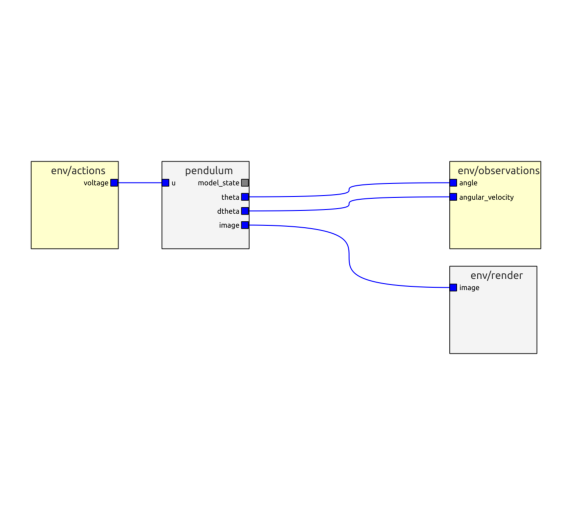

In [5]:
!{"pip install eagerx-gui >> /tmp/eagerx_gui.txt 2>&1"}
from matplotlib import pyplot as plt

# Render GUI
gui_render = graph.gui(interactive=False)

# Show GUI render
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.axis("off")
plt.imshow(gui_render)
plt.show()

In [6]:
It is also possible to inspect the graph using the eagerx-gui package.
It can be installed as follows:
```bash
pip3 install eagerx-gui
```
Jupyter notebooks have limited support for interactive applications, so we cannot open the GUI here.
But if we were to run
```python
graph.gui()
```
The ouput would be as follows:

<img src="./figures/tutorial_1_gui.svg" width=720>

Here we see that the actions of the agent are outputs of *env/actions* and that the observations of the agent are inputs of *env/observations*.
Also, we could render output by connecting to *env/render*, which will be covered in another tutorial.
Note that *env/actions*, *env/observations* and *env/render* represent connections of the `Graph` to the environment.
They are split up in the GUI as nodes for visualization purposes.

Next, we will create the [Environment](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html).
Environment creation in EAGERx follows the same API as Gym, i.e. we have to define a [step()](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html#eagerx.core.env.BaseEnv.step) and [reset()](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html#eagerx.core.env.BaseEnv.reset) method.

Just like in normal Gym environments, we will create a step function in which we will calculate the reward at each time step and check for termination conditions.
Our goal is to stabilize the pendulum in upright position, while minimizing the input voltage that is applied.
Therefore we choose a reward function that is a weighted sum of $\theta^2$, $\dot{\theta^2}$ and $u^2$.

Note that we can obtain the values of the actions and observations using the keys *voltage*, *angle* and *angular_velocity*, which correspond to the names of the actions and observations above in the screenshot of the GUI.

SyntaxError: invalid syntax (770376167.py, line 1)

Next, we will make a specification with which we can initialize an [Engine](https://eagerx.readthedocs.io/en/master/guide/api_reference/engine/index.html).
Since objects can have implementions for multiple physics engines and real systems, we need to initialize the appropriate engine.
In our case, we will use the [OdeEngine](https://github.com/eager-dev/eagerx_ode), which allows to simulate systems based on ordinary differential equations (ODEs).
In more advanced tutorials we will go more into detail on the engine and how you can create your own engine.

In [7]:
from eagerx_ode.engine import OdeEngine

# Make the engine specification
engine = OdeEngine.make(rate=rate)

Then, we will make a specification with which we can initialize an [Backend](https://eagerx.readthedocs.io/en/master/guide/api_reference/backend/index.html). The backend takes care of all communication between nodes and manages the parameter server. Depending on the backend, the support for [distributed computation](https://en.wikipedia.org/wiki/Distributed_computing), [Google Colab](https://colab.research.google.com/?utm_source=scs-index), and [multi-processing](https://en.wikipedia.org/wiki/Multiprocessing) may differ. There are already two backends available, but users can also define their own:

|  | Google Colab | Distributed | Multi-processing |
| ---- | --- | --- | --- |
| eagerx.backends.ros1.Ros1 | <center>&cross;</center> | <center>&#10004;</center> | <center>&#10004;</center> |
| eagerx.backends.single_process.SingleProcess | <center>&#10004;</center> | <center>&cross;</center> | <center>&cross;</center> |


In [8]:
from eagerx.backends.single_process import SingleProcess

# Make the backend specification
backend = SingleProcess.make()

Having created a graph, an engine and a step function, we can now construct the EAGERx environment.
We can use it like any other Gym environment.
Here we will now train a policy to swing up the pendulum using the Soft Actor Critic (SAC) reinforcement learning algorithm implementation from [Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/).

In [9]:
import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from eagerx.wrappers import Flatten
from gym.wrappers.rescale_action import RescaleAction

# Initialize Environment
env = PendulumEnv(name="PendulumEnv", rate=rate, graph=graph, engine=engine, backend=backend)

# Print action & observation space
print("action_space: ", env.action_space)
print("observation_space: ", env.observation_space)

# Stable Baselines3 expects flattened actions & observations
# Convert observation and action space from Dict() to Box(), normalize actions
env = Flatten(env)
env = RescaleAction(env, min_action=-1.0, max_action=1.0)

# Check that env follows Gym API and returns expected shapes
check_env(env)

# Toggle render
env.render("human")

# Initialize learner
model = sb3.SAC("MlpPolicy", env, verbose=1)

# Train for 1 minute (sim time)
model.learn(total_timesteps=int(60 * rate))

env.shutdown()

[WARN]: Backend 'SINGLE_PROCESS' does not support multiprocessing, so all nodes are launched in the ENVIRONMENT process.
action_space:  Dict(voltage:Space([-2.], [2.], (1,), float32))
observation_space:  Dict(angle:Box([-999.], [999.], (1,), float32), angular_velocity:Box([-999.], [999.], (1,), float32))
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -1.05e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 81        |
|    time_elapsed    | 4         |
|    total_timesteps | 404       |
| train/             |           |
|    actor_loss      | 18.8      |
|    critic_loss     | 15        |
|    ent_coef        | 0.915     |
|    ent_coef_loss   | -0.132    |
|    learning_rate   | 0.0003    |
|    n_updates       | 303       |
----------------------------------
----

### Note
This environments runs without errors, but the agent will not yet learn to swing up the pendulum... In the next tutorials you will find out why (*hint: it has to do with the definition of the spaces*), and how you can use eagerx to easily redefine this environment. 